「RとStanで始めるベイズ統計モデリングによるデータ分析入門 実践編第7章 正規線形モデル」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備

## パッケージの読み込み

In [2]:
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# データの読み込みと図示

## 分析対象のデータ

In [4]:
sales_climate = pd.read_csv('3-7-1-beer-sales-4.csv')
sales_climate.head(n=3)

,sales,weather,temperature
0,40.643344,cloudy,13.7
1,99.552683,cloudy,24.0
2,85.326847,cloudy,21.5


## データの要約

In [5]:
sales_climate.describe(include='all')

,sales,weather,temperature
count,150.000000,150,150.000000
unique,NaN,3,NaN
top,NaN,cloudy,NaN
freq,NaN,50,NaN
mean,79.583818,NaN,19.914667
std,25.889507,NaN,5.908853
min,26.059938,NaN,10.100000
25%,61.192714,NaN,14.825000
50%,80.551565,NaN,19.000000
75%,96.109083,NaN,25.350000


## 図示

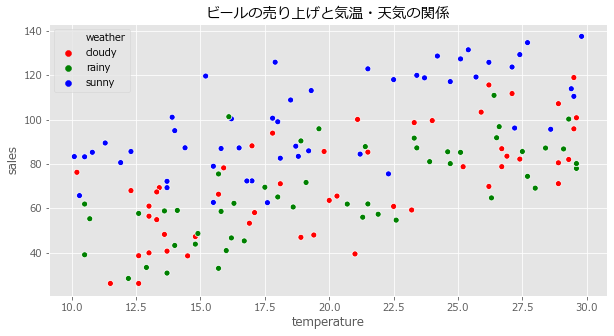

In [21]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='temperature',
                y='sales',
                data=sales_climate,
                hue='weather',
                hue_order=['cloudy', 'rainy', 'sunny'],
                palette=['red', 'green', 'blue'])
plt.title('ビールの売り上げと気温・天気の関係')
plt.show()

# brmsによる分散分析モデルの推定

pythonにbrmsの代用可能なパッケージが知っている範囲内で存在しないため，brmsを利用したコードは省略しています。

# 補足：正規線形モデルのデザイン行列

## デザイン行列の作成

In [7]:
design_mat = pd.get_dummies(sales_climate.drop('sales',axis=1), drop_first=True)         # ダミー変数処理
design_mat.insert(0, '(Intercept)', 1)                                                    # (Intercept)列追加
design_mat = design_mat[['(Intercept)', 'weather_rainy', 'weather_sunny', 'temperature']] # 列名並び替え
design_mat.head(n=3)

,(Intercept),weather_rainy,weather_sunny,temperature
0,1,0,0,13.7
1,1,0,0,24.0
2,1,0,0,21.5


## dictにまとめる

In [15]:
data_list_design = dict(N=len(design_mat),
                        K=design_mat.shape[1],
                        Y=sales_climate['sales'],
                        X=design_mat,
                        N_temperature = len(np.arange(10,31,1)),
                        temperature = np.arange(10,31,1))

## MCMCの実行

In [18]:
# stanコードの記述
stan_code = '''
data { 
  int N;                // サンプルサイズ
  int K;                // デザイン行列の列数(説明変数の数＋１)
  vector[N] Y;          // 応答変数 
  matrix[N, K] X;       // デザイン行列 
  int N_temperature;
  vector[N_temperature] temperature;
   
} 

parameters { 
  vector[K] b;          // 切片を含む係数ベクトル
  real<lower=0> sigma;  // データのばらつきを表す標準偏差
} 

model { 
  vector[N] mu = X * b;
  Y ~ normal(mu, sigma);
} 

generated quantities {
    vector[N_temperature] mu_pred_cloudy;
    vector[N_temperature] mu_pred_rainy;
    vector[N_temperature] mu_pred_sunny;
    for(i in 1:N_temperature){
        mu_pred_cloudy[i] = (b[1] + b[2]*0 + b[3]*0 + b[4]*temperature[i]);
        mu_pred_rainy[i] =  (b[1] + b[2]*1 + b[3]*0 + b[4]*temperature[i]);
        mu_pred_sunny[i] =  (b[1] + b[2]*0 + b[3]*1 + b[4]*temperature[i]);
    }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
lm = stan_model.sampling(data=data_list_design, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce7d90323518c5b80d3068d70dcf7538 NOW.


In [19]:
lm

Inference for Stan model: anon_model_ce7d90323518c5b80d3068d70dcf7538.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]                20.32    0.12    5.1  10.46  16.97   20.2   23.7  30.69   1788    1.0
b[2]                -3.55    0.07   3.21  -9.85  -5.74  -3.49  -1.42   2.58   2258    1.0
b[3]                29.39    0.07    3.2  23.28  27.25  29.34  31.49  35.88   2257    1.0
b[4]                 2.54  4.9e-3   0.22   2.09    2.4   2.54   2.69   2.98   2024    1.0
sigma               16.04    0.02   0.93  14.32  15.39  16.01  16.62  17.97   3069    1.0
mu_pred_cloudy[1]   45.76    0.08   3.26   39.5  43.56  45.76  47.95  52.23   1802    1.0
mu_pred_cloudy[2]   48.31    0.07    3.1  42.39  46.22  48.31  50.38  54.39   1816    1.0
mu_pred_cloudy[3]   50.85    0.07   2.95  45.13  48.85  50.87  52.81  56.61   1837    1.0
m

In [23]:
mcmc_sample = lm.extract()

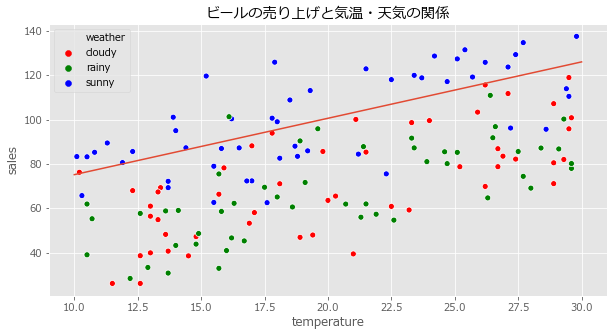

In [36]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='temperature',
                y='sales',
                data=sales_climate,
                hue='weather',
                hue_order=['cloudy', 'rainy', 'sunny'],
                palette=['red', 'green', 'blue'])
plt.plot(np.arange(10,31,1),mcmc_sample['mu_pred_sunny'].mean(axis=0))
plt.title('ビールの売り上げと気温・天気の関係')
plt.show()

In [ ]:

plt.plot(xrange,
         xrange * summary['mean']['b[4]'] + summary['mean']['b[1]'],
         color='red',
         alpha=0.5)
plt.fill_between(x=xrange,
                 y1=list(itertools.chain.from_iterable(p)),
                 y2=list(itertools.chain.from_iterable(q)))
plt.plot(xrange,
         xrange * summary['mean']['b[4]'] + summary['mean']['b[1]'] +
         summary['mean']['b[2]'],
         color='green',
         alpha=0.5)
plt.plot(xrange,
         xrange * summary['mean']['b[4]'] + summary['mean']['b[1]'] +
         summary['mean']['b[3]'],
         color='blue',
         alpha=0.5)

sns.scatterplot(x='temperature',
                y='sales',
                data=sales_climate,
                hue='weather',
                hue_order=['cloudy', 'rainy', 'sunny'],
                palette=['red', 'green', 'blue'],
                alpha=0.5)